In [32]:
import importlib
import src.evaluation

importlib.reload(src.evaluation)

<module 'src.evaluation' from 'C:\\Users\\lovas\\Desktop\\Market_risk_prediction\\src\\evaluation.py'>

In [43]:
import pandas as pd
from joblib import dump, load

import sys
from pathlib import Path

# Add project root to sys.path
project_root = Path().resolve().parent # assumes notebook is in a subdirectory of the project root
sys.path.append(str(project_root))

from src.models import get_deep_rf, get_shallow_rf, get_xgb
from src.utils import best_threshold
from src.evaluation import give_metrics

In [4]:
sp500 = pd.read_csv(project_root / "data/processed/sp500_processed.csv", index_col=0, parse_dates=True)

In [35]:
X_train, X_test = sp500.loc[:'2018'].drop('Stress', axis=1), sp500.loc['2019':].drop('Stress', axis=1)
y_train, y_test = sp500.loc[:'2018', 'Stress'], sp500.loc['2019':, 'Stress']

# So that we wont learn the specifics of the timeframe
# Makes it more 'structural'
normalized_features = ['Vol20/VIX', 'Vol5/VIX', 'Scaled_Lag_1d', 'Scaled_Lag_3d',
                       'Sharpe-like_10', 'Sharpe-like_5', 'log_returns_zscore' ,'VIX_zscore']

normalized_features += ['Momentum5_20', 'Momentum10_20', 'Momentum5_10', 'Momentum3_20', 'Momentum3_10', 'Momentum3_5'] # 5_20 is the original
normalized_features += ['Scaled_weighted_avg']

# Skew and Kurtosis seems to make things worse
# Scaled_Lag_5d also seemed bad
# Vol_momentum tends towards not being useful

# More generally seems like longer timeframe stats are better (except lagged returns)

# -- added ['Momentum5_20', 'Momentum10_20', 'Momentum5_10', 'Momentum3_20', 'Momentum3_10', 'Momentum3_5'] and df['Scaled_weighted_avg']

X_train = X_train[normalized_features]
X_test = X_test[normalized_features]

In [36]:
shallow_rf = get_shallow_rf()
shallow_rf.fit(X_train, y_train)

deep_rf = get_deep_rf()
deep_rf.fit(X_train, y_train)

xgb = get_xgb()
xgb.fit(X_train, y_train, eval_set=[(X_test, y_test)],verbose=False)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=40,
              enable_categorical=False, eval_metric='aucpr', feature_types=None,
              feature_weights=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.2, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=5,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=1000,
              n_jobs=None, num_parallel_tree=None, ...)

In [37]:
s_pred_proba = shallow_rf.predict_proba(X_test)[:, 1]
s_preds = s_pred_proba > best_threshold(y_test, s_pred_proba)

d_pred_proba = deep_rf.predict_proba(X_test)[:, 1]
d_preds = d_pred_proba > best_threshold(y_test, d_pred_proba)

xgb_pred_proba = xgb.predict_proba(X_test)[:, 1]
xgb_preds = xgb_pred_proba > best_threshold(y_test, xgb_pred_proba)

0.47999999999999976
0.42999999999999977
0.6749999999999997


In [38]:
metrics = give_metrics(y_test, s_preds, s_pred_proba, model_name='Shallow RF')
metrics = give_metrics(y_test, d_preds, d_pred_proba, model_name='Deep RF', df=metrics)
metrics = give_metrics(y_test, xgb_preds, xgb_pred_proba, model_name='XGBoost', df=metrics)

metrics

,Accuracy,Precision,Recall,F1 Score,ROC AUC,Average Precision
Shallow RF,0.776786,0.138528,0.551724,0.221453,0.741942,0.132809
Deep RF,0.826389,0.161850,0.482759,0.242424,0.750835,0.147437
XGBoost,0.908730,0.242424,0.275862,0.258065,0.704328,0.158123


In [45]:
dump(shallow_rf, project_root / 'results/models/shallow_rf.joblib')
dump(deep_rf, project_root / 'results/models/deep_rf.joblib')
dump(xgb, project_root / 'results/models/xgb.joblib')

['C:\\Users\\lovas\\Desktop\\Market_risk_prediction\\results\\models\\xgb.joblib']

In [39]:
from src.MyPlotting import plot_pr_curve, plot_permutation_importance

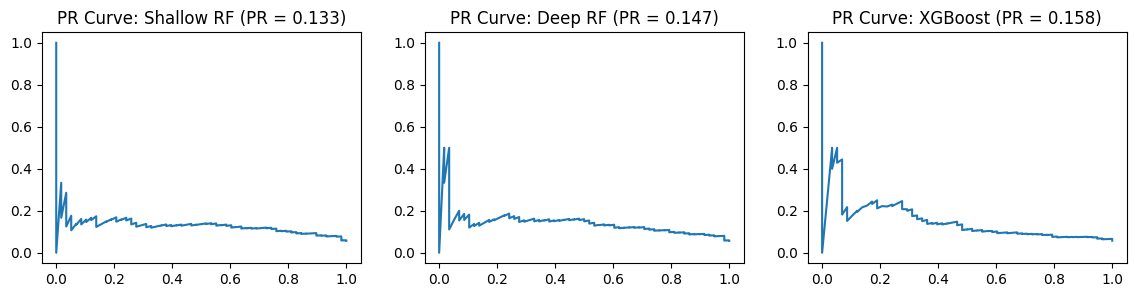

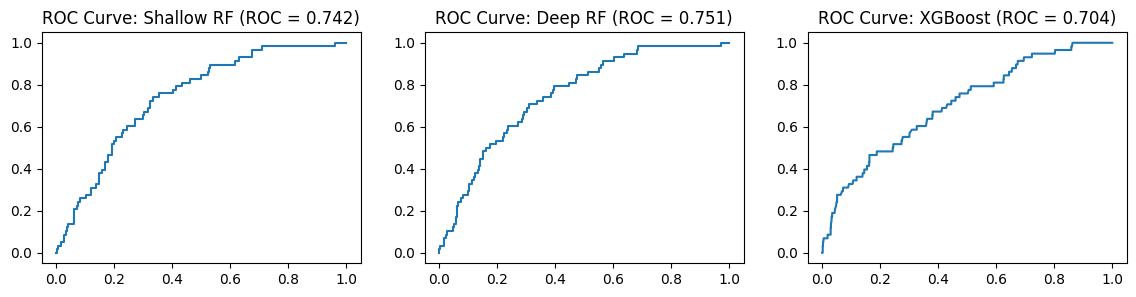

In [ ]:
plot_pr_curve(y_test, X_test, [shallow_rf, deep_rf, xgb],
              model_names=['Shallow RF', 'Deep RF', 'XGBoost'])
plot_pr_curve(y_test, X_test, [shallow_rf, deep_rf, xgb],
              model_names=['Shallow RF', 'Deep RF', 'XGBoost'], curve_type='ROC')
# making them on a single plot might be nice

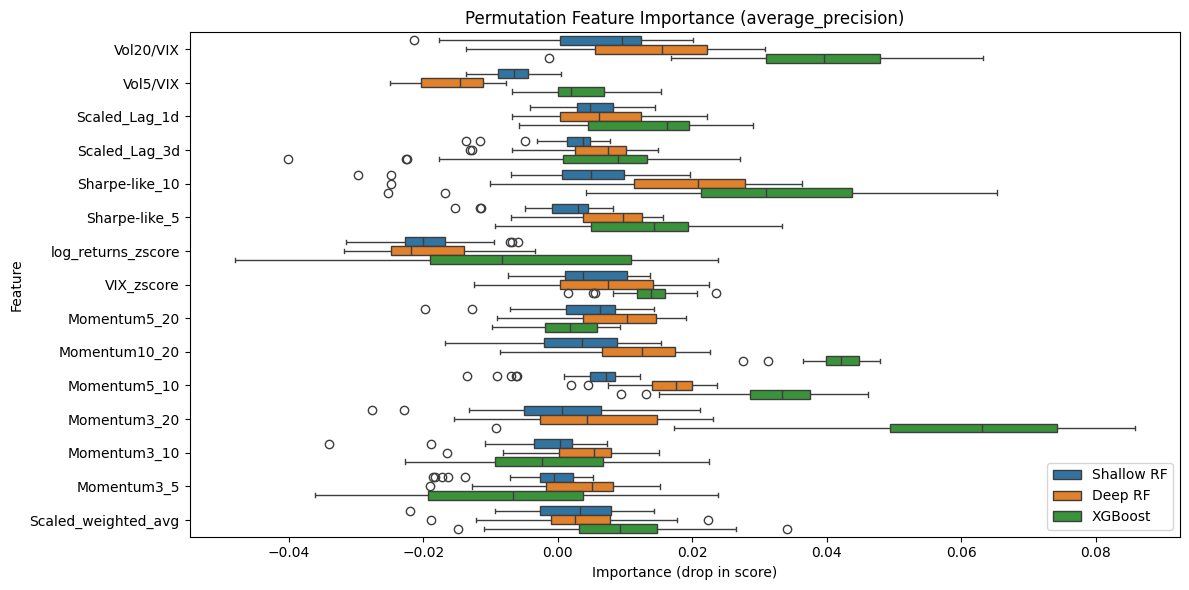

In [42]:
plot_permutation_importance([shallow_rf, deep_rf, xgb], X_test, y_test, model_names=['Shallow RF', 'Deep RF', 'XGBoost'], scoring='average_precision')